### Resources:
- [TensorFlow - Word2Vec Tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html)
- [TensorFlow - GitHub](https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

# Goal
- To create a vector based representations of words (embeddings) using the word2vec model.

In [1]:
import tensorflow as tf
import collections
import operator
import numpy as np
import random
import math

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
% matplotlib inline

# Parameters

### Learning Parameters

In [2]:
LEARNING_RATE = 1.0   # How much we move our gradient parameters per episode
EPISODES = 300         # Total episodes
PRINT = 50            # Print info every x itteration

### Skip-Gram Parameters

In [3]:
# REMINDER: vocab_size = 9412
BATCH_SIZE = 64       # Number of input examples in input matrix (64 x 1)
EMBEDDING_SIZE = 128  # Dimension of the embedding vector.
SKIP_WINDOW = 1       # How many words to consider left and right.
NUM_SKIPS = 2         # How many times to reuse an input to generate a label.

### Validation Parameters
- We pick a random validation set to sample nearest neighbors.
- Here we limit the validation samples to the words that have a low numeric ID, which by construction are also the most frequent.

In [4]:
VALID_SIZE = 16     # Random set of words to evaluate similarity on.
VALID_WINDOW = 100  # Only pick dev samples in the head of the distribution.
NUM_SAMPLED = 64    # Number of negative examples to sample.

valid_examples = np.random.choice(VALID_WINDOW, VALID_SIZE, replace=False)

# Data

### Import

In [5]:
# Reads text to string
with open("scraped_jokes.txt", 'r') as fp:
    raw_str = fp.read()
    
raw_str[0:100]

" The Battle of the Nile. Two naval officers were disputing as to the importance of Lord Nelson's vic"

### Word List

In [6]:
# Splits and lists each each word
words_list = tf.compat.as_str(raw_str).split()

words_list[0:5]

['The', 'Battle', 'of', 'the', 'Nile.']

In [7]:
# Vocabulary size
vocab_size = len(words_list)

vocab_size

9412

### Frequency List

In [8]:
# import collections

# Initiates unknown character counter
frequency_list = [['UNK', -1]]

# Word frequency tuple sorted by most common
frequency_list.extend(collections.Counter(words_list).most_common(vocab_size - 1))

frequency_list[0:5]

[['UNK', -1], ('the', 468), ('of', 413), ('a', 274), ('to', 226)]

In [9]:
len(frequency_list)

3904

### Value Mapping Dictionary

In [10]:
# import operator

# Dictionary of unique words with an index
val_map_dict = dict()
for word, _ in frequency_list:
    val_map_dict[word] = len(val_map_dict)

In [11]:
sorted(val_map_dict.items(), key=operator.itemgetter(0))[0:3] # Sorted by key

[('!"', 3624), ('"', 29), ('""Iunderstand,"', 2128)]

In [12]:
sorted(val_map_dict.items(), key=operator.itemgetter(1))[0:3] # Sorted by value

[('UNK', 0), ('the', 1), ('of', 2)]

### Index Text

In [13]:
index_text = []
unk_count = 0

# Maps each word in our corpus to it's index value
for word in words_list:    
    if word in val_map_dict:
        index = val_map_dict[word] # Store the words index number
    else:
        index = 0  # # Store the int zero - dictionary['UNK']
        unk_count += 1 # Keep track of how many unknowns we have
    
    # Make a list of all our word indexes and unknowns
    index_text.append(index)

index_text[0:10]

[11, 848, 2, 1, 2172, 261, 620, 901, 69, 1246]

In [14]:
# Add the new unknowns to our cout tuple
frequency_list[0][1] = unk_count

frequency_list[0][1]

0

### Reverse Dictionary

In [15]:
reverse_dictionary = dict(zip(val_map_dict.values(), val_map_dict.keys()))

# Gives us a new reverse dictionary with the numbers as keys
{k: reverse_dictionary[k] for k in sorted(reverse_dictionary.keys())[:10]}
print('Sample index_text', index_text[:10], [reverse_dictionary[i] for i in index_text[:10]])

Sample index_text [11, 848, 2, 1, 2172, 261, 620, 901, 69, 1246] ['The', 'Battle', 'of', 'the', 'Nile.', 'Two', 'naval', 'officers', 'were', 'disputing']


### Batch Functions
- This function will be called to generate new data on each learning iteration. 
- The way this function is built determins if our Word2Vec model is using the the continuous bag-of-words or skip-gram configuration.

In [16]:
# import numpy as np
# import random

data_index = 0

def generate_batch(BATCH_SIZE, NUM_SKIPS, SKIP_WINDOW):
    global data_index
    assert BATCH_SIZE % NUM_SKIPS == 0
    assert NUM_SKIPS <= 2 * SKIP_WINDOW
    batch = np.ndarray(shape=(BATCH_SIZE), dtype=np.int32)
    labels = np.ndarray(shape=(BATCH_SIZE, 1), dtype=np.int32)
    span = 2 * SKIP_WINDOW + 1 # [ SKIP_WINDOW target SKIP_WINDOW ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(index_text[data_index])
        data_index = (data_index + 1) % len(index_text)
    for i in range(BATCH_SIZE // NUM_SKIPS):
        target = SKIP_WINDOW  # target label at the center of the buffer
        targets_to_avoid = [ SKIP_WINDOW ]
        for j in range(NUM_SKIPS):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * NUM_SKIPS + j] = buffer[SKIP_WINDOW]
            labels[i * NUM_SKIPS + j, 0] = buffer[target]
        buffer.append(index_text[data_index])
        data_index = (data_index + 1) % len(index_text)
    return batch, labels

# Graph

### Layer 0 (Input)

In [17]:
# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[BATCH_SIZE])
train_labels = tf.placeholder(tf.int32, shape=[BATCH_SIZE, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Layer 1 (Output)

In [18]:
# Look up embeddings for inputs.
embeddings = tf.Variable(tf.random_uniform([vocab_size, EMBEDDING_SIZE], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [19]:
# import math

# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocab_size, EMBEDDING_SIZE], stddev=1.0 / math.sqrt(EMBEDDING_SIZE)))
nce_biases = tf.Variable(tf.zeros([vocab_size]))

### Cost
- Compute the average NCE loss for the batch.
- tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss.

In [20]:
# Compute the average NCE loss for the batch.
cost = tf.reduce_mean( tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels, NUM_SAMPLED, vocab_size))

### Optimizer

In [21]:
# Optimizer: SGD
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

### Similarity

In [22]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Training

In [23]:
# Interactive TensorFlow session.
sess = tf.InteractiveSession()

In [24]:
# Initialize all vars
sess.run(tf.initialize_all_variables())

In [25]:
num_steps = 10

# Train & Log
for ep in range(EPISODES):
    
    # Specify our batch size
    batch_inputs, batch_labels = generate_batch(BATCH_SIZE, NUM_SKIPS, SKIP_WINDOW)
    batch_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    
    # Iterativly runs our optimizer
    sess.run(optimizer, feed_dict=batch_dict)
    sess.run(cost, feed_dict=batch_dict)

    # Print
    if (ep+1) == 1 or (ep+1) % PRINT == 0:
        print("Ep:", ep+1)     
        print("Cost", sess.run(cost, feed_dict=batch_dict))
        # print("Similarity", sess.run(similarity, feed_dict=batch_dict))
        
    final_embeddings = normalized_embeddings.eval()

Ep: 1
Cost 226.624
Ep: 50
Cost 122.074
Ep: 100
Cost 130.618
Ep: 150
Cost 108.009
Ep: 200
Cost 103.824
Ep: 250
Cost 71.3766
Ep: 300
Cost 59.3736


In [26]:
# Close an interactive TensorFlow Session when we're done.
sess.close()

# Visualize Embeddings
- [scikit-learn update reminder](https://github.com/scikit-learn/scikit-learn/issues/6665)

In [27]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels):
    
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(15, 15))  # in inches
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

### t-SNE
- t-SNE helps us visualize higher dimensional data by converting the similarities between data points to joint probabilities then minimizing the kL divergence.

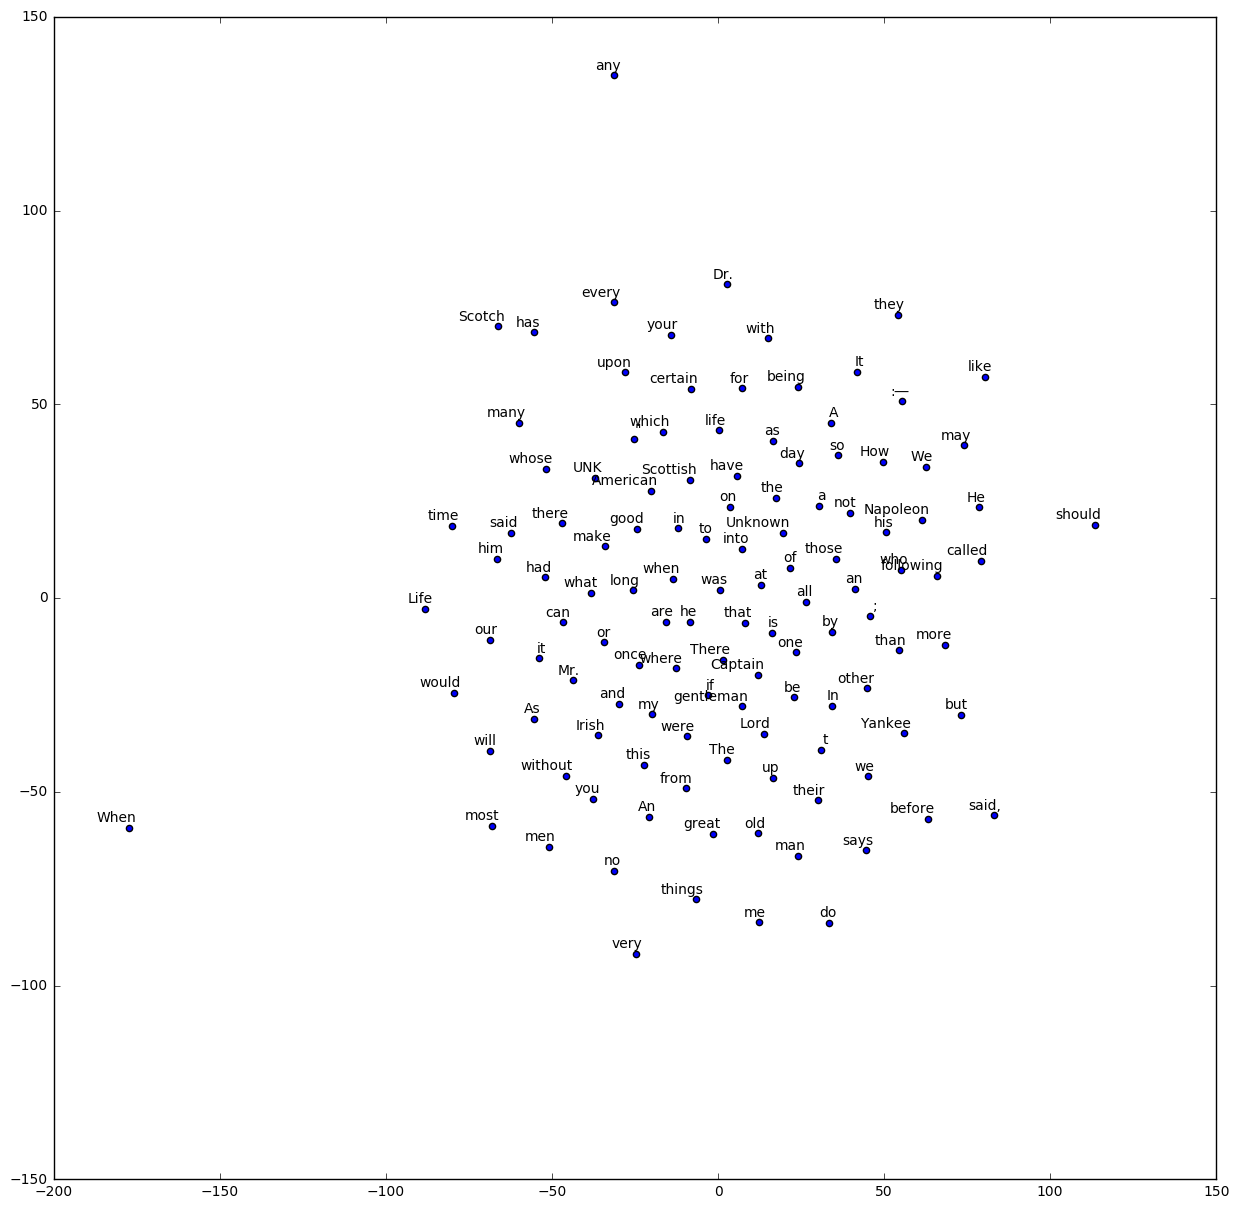

In [28]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

# Decides number of words to return
plot_only = 120
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

plot_with_labels(low_dim_embs, labels)